In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import random
import seaborn as sns
import pandas as pd
device = "cpu"
from copy import deepcopy

In [2]:
def set_seed():
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # If using CUDA

In [3]:
def lin_y(X: np.array, w: np.array, var: float):
    if len(w.shape) == 1:
        w = w.reshape(-1, 1)
    assert X.shape[1] == len(w), "Input array must be of same shape as the weight vector"
    result = X @ w
    exog = np.random.randn(len(X)) * np.sqrt(var)
    return [result.reshape(-1, 1), exog.reshape(-1, 1)]

In [4]:
class LinearModel(nn.Module):
    def __init__(self, num_params):
        super(LinearModel, self).__init__()
        self.num_params = num_params

    def fit(self, X, y):
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        yhat = X @ self.w
        yhat = yhat.reshape(-1, 1)
        return yhat

    def forward(self, X):
        return self.predict(X)

In [5]:
Gauss = np.random.normal
variances = [5]
trn_sizes = [50]

Generate the datasets such that the last three features are correlated with the first three features dependoing on the $\rho$

In [6]:
results_ndim = {}
set_seed()

def generate_data(num_samples, ndim, corr):
    base_X = Gauss(0, 1, (num_samples, 3))
    X = [base_X]
    num_rpt = ndim // 3
    for i in range(num_rpt - 1):
        X.append(base_X + Gauss(0, corr, (num_samples, 3)))
    X = np.concatenate(X, axis=1)
    assert X.shape == (num_samples, ndim), f"Shape of X is {X.shape}"
    return X


ndim = 6
w = Gauss(0, 1, (ndim, 1))
# w[3:] = 0

corrs =  [0.01, 0.05, 0.1, 0.5, 1]

for corr in corrs:
    results = {}
    # Sample the w for linear function
    for var in  variances:
        results[var] = {}
        # %% Generate the same Val and Tst set for a fixed value of variance.
        XVal, XTst = generate_data(100, ndim, corr), generate_data(100, ndim, corr)
        XFix = np.copy(XTst)

        # Generate the superset of all the training samples at once.
        AllXTrn = generate_data(1000, ndim, corr)

        # Inject root cause into the Testcases
        for i in range(len(XFix)):
            XTst[i, np.random.choice(3)] = np.random.uniform(3, 10) # This is the root cause

        y_dict = {
            "Val": {
                "lin": lin_y(XVal, w, var),
            },
            "Tst": {
                "lin": lin_y(XTst, w, var),
            },
            "Fix": {
                "lin": lin_y(XFix, w, var),
            },
            "AllTrn": {
                "lin": lin_y(AllXTrn, w, var),
            }
        }

        # For the fix use the same exogenous variable as the test
        y_dict["Fix"]["lin"][1] = np.copy(y_dict["Tst"]["lin"][1])

        for size in trn_sizes:
            results[var][size] = {}

            error_keys = ["lin_val_error", "lin_tst_error", "lin_int_error", "lin_cf_error"]
            for key in error_keys:
                results[var][size][key] = []

            for run in [1, 2, 3, 4, 5]:
                # Take the first size samples for training
                XTrn = AllXTrn[:size]
                try:
                    del y_dict["Trn"]
                except:
                    pass
                y_dict["Trn"] = {
                    "lin": [y_dict["AllTrn"]["lin"][0][:size], y_dict["AllTrn"]["lin"][1][:size]],
                }

                # %% Fit the Models
                lin_model = LinearModel(ndim)

                lin_model.fit(XTrn, y_dict["Trn"]["lin"][0] + y_dict["Trn"]["lin"][1])
                
                # print(f"Var: {var}, size: {size}, ndim: {ndim}\t wstatr: {w.squeeze()} \t wfit: {lin_model.w.squeeze()}")

                # %% Val Errors
                lin_val = lin_model.predict(XVal)
                lin_val_res = (y_dict["Val"]["lin"][0] + y_dict["Val"]["lin"][1] - lin_val).reshape(-1, 1)
                lin_val_error = np.mean((y_dict["Val"]["lin"][0] - lin_val)**2) # Just assess the f_4 prediction accuracies and not the X_4 on val data that has all usual parents.
                results[var][size]["lin_val_error"].append(lin_val_error)

                # %% Tst Errors
                lin_tst = lin_model.predict(XTst)
                lin_tst_res = (y_dict["Tst"]["lin"][0] + y_dict["Tst"]["lin"][1] - lin_tst).reshape(-1, 1)

                # Just assess the f_4 prediction accuracies and not the X_4 on test data that has an abnormal a.k.a OOD parent.
                lin_tst_error = np.mean((y_dict["Tst"]["lin"][0] - lin_tst)**2)
                results[var][size]["lin_tst_error"].append(lin_tst_error)

                # %% Int Error
                lin_int = lin_model.predict(XFix)
                lin_int = (lin_int + np.mean(lin_val_res.squeeze())).reshape(-1, 1)
                lin_int_error = np.mean((y_dict["Fix"]["lin"][0] + y_dict["Fix"]["lin"][1] - lin_int)**2) # Assess the error between the true CD XFix_4 and the int estimate
                results[var][size]["lin_int_error"].append(lin_int_error)

                # %% CF Error
                lin_cf = lin_model.predict(XFix)
                lin_cf = lin_cf + lin_tst_res
                lin_cf_error = np.mean((y_dict["Fix"]["lin"][0] + y_dict["Fix"]["lin"][1] - lin_cf)**2)
                results[var][size]["lin_cf_error"].append(lin_cf_error)

            for key in error_keys:
                results[var][size][key] = np.mean(results[var][size][key])

    results_ndim[corr] = deepcopy(results)


In [7]:
import pandas as pd
cols = ['lin_val_error',  'lin_tst_error', 'lin_int_error', 'lin_cf_error']
dfs = {}

for corr in results_ndim.keys():
    dfs[corr] = {}
    results = results_ndim[corr]
    for var in results.keys():
        df = {}
        for col in cols:
            df[col] = []
            for size in trn_sizes:
                df[col].append(results[var][size][col])
        df = pd.DataFrame(df)
        df.index = trn_sizes
        dfs[corr][var] = df

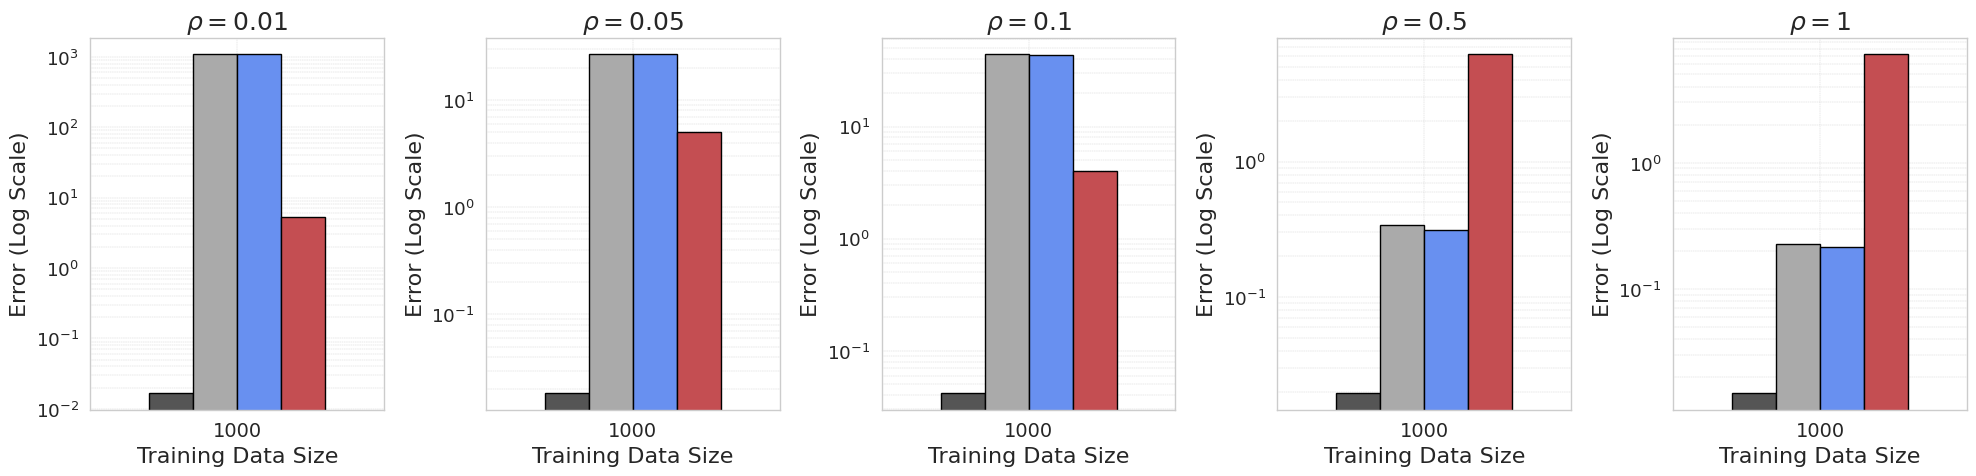

In [8]:
import matplotlib.pyplot as plt
var_dict = {
    0.5: "Low",
    1: "Medium",
    2: "High",
    5: "Very High"
}
title_size = 18
label_size = 16
tick_size = 14

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for corr_idx, corr in enumerate(dfs.keys()):        
    df = dfs[corr][var]
    lin_bars = ["lin_val_error", "lin_tst_error", "lin_cf_error", "lin_int_error"]

    lin_bars_name = ["Validation", "Test", "Counterfactual",  "Intervention"]

    # bar_colors =  ['#1b9e77', '#fdaa48','#6890F0', 'r']
    bar_colors = ['#555555', '#aaaaaa', '#6890F0', 'r']

    bar_line_width = 1
    bar_width = 0.75

    df[lin_bars].plot(kind='bar', ax=ax[corr_idx], color=bar_colors, linewidth=bar_line_width, width=bar_width, edgecolor='black')
    ax[corr_idx].set_title(r'$\rho={}$'.format(round(corr, 2)), fontsize=title_size)
    ax[corr_idx].set_xlabel("Training Data Size", fontsize=label_size)
    ax[corr_idx].set_ylabel("Error (Log Scale)", fontsize=label_size)
    ax[corr_idx].set_yscale('log')
    ax[corr_idx].set_xticklabels(trn_sizes, rotation=0, fontsize=tick_size)
    ax[corr_idx].legend().set_visible(False)
    ax[corr_idx].grid(True, which='both', linestyle='--', lw=0.3)
plt.tight_layout()
# plt.show()
plt.savefig("corr_1000.pdf", bbox_inches='tight')